# Geopandas: an introduction

In this section, we will cover the basics of *geopandas*, a Python library to
interact with geospatial vector data.

[Geopandas](https://geopandas.org/) provides an easy-to-use interface to vector
data sets. It combines the capabilities of *pandas*, the data analysis package
we got to know in the [Geo-Python
course](https://geo-python-site.readthedocs.io/en/latest/lessons/L5/pandas-overview.html),
with the geometry handling functionality of
[shapely](../lesson-1/geometry-objects), the [geo-spatial file format support
of fiona](vector-data-io) and the [map projection libraries of
pyproj](map-projections).

The main data structures in geopandas are `GeoDataFrame`s and `GeoSeries`. They
extend the functionality of `pandas.DataFrame`s and `pandas.Series`. This means
that **we can use all our *pandas* skills also when we work with
*geopandas*!**. 

:::{tip}

If you feel like you need to refresh your memory about pandas, head back to
[lesson
5](https://geo-python-site.readthedocs.io/en/latest/lessons/L5/pandas-overview.html)
and [lesson
6](https://geo-python-site.readthedocs.io/en/latest/notebooks/L6/advanced-data-processing-with-pandas.html)
of Geo-Python.
:::

There is one key difference between pandas’s data frames and geopandas’
[`GeoDataFrame`s](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe):
a `GeoDataFrame` contains an additional column for geometries. By default, the
name of this column is `geometry`, and it is a
[`GeoSeries`](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geoseries)
that contains the geometries (points, lines, polygons, ...) as
`shapely.geometry` objects.

In [1]:
import pathlib
import geopandas
import numpy
import pandas

DATA_DIRECTORY = pathlib.Path().resolve() / "data"

HIGHLIGHT_STYLE = "background: #f66161;"

# so the following block is a bit of bad magic to make the table output look
# nice (this cell is hidden, we are only interested in a short table listing
# in which the geometry column is highlighted).
#
# For this, we
#    1. convert the geopandas back into a ‘normal’ pandas.DataFrame with a shortened
#       WKT string in the geometry column
#    1b. while doing so, get rid of most of the columns (rename the remaining ones)
#    2. apply the style to all cells in the column "geometry", and to the axis-1-index "geometry"

# Why did I got via a ‘plain’ `pandas.DataFrame`?
# `pandas.set_option("display.max_colwidth", 40)` was ignored, so this seemed like the cleanest way

df = geopandas.read_file(DATA_DIRECTORY / "finland_topographic_database" / "m_L4132R_p.shp")

df["geom"] = df.geometry.to_wkt().apply(lambda wkt: wkt[:40] + " ...")

df = df[["RYHMA", "LUOKKA", "geom"]]
df = df.rename(columns={"RYHMA": "GROUP", "LUOKKA": "CLASS", "geom": "geometry"})

(
    df.head().style
        .applymap(lambda x: HIGHLIGHT_STYLE, subset=["geometry"])
        .apply_index(lambda x: numpy.where(x.isin(["geometry"]), HIGHLIGHT_STYLE, ""), axis=1)
)

---


## Input data: Finnish topographic database 

In this lesson, we will work with the [National Land Survey of Finland (NLS)/Maanmittauslaitos (MML) topographic database](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/expert-users/product-descriptions/topographic-database). 
- The data set is licensed under the NLS’ [open data licence](https://www.maanmittauslaitos.fi/en/opendata-licence-cc40) (CC BY 4.0).
- The structure of the data is described in a [separate Excel file](http://www.nic.funet.fi/index/geodata/mml/maastotietokanta/2022/maastotietokanta_kohdemalli_eng_2019.xlsx).
- Further information about file naming is available at [fairdata.fi](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae) (this link relates to the 2018 issue of the topographic database, but is still valid).

For this lesson, we have acquired a subset of the topographic database as
shapefiles from the Helsinki Region in Finland via the [CSC’s Paituli download
portal](https://paituli.csc.fi). You can find the files in `data/finland_topographic_database/`.

:::{figure} ../../static/images/lesson-2/paituli-download_700x650px.png
:alt: Screenshot of the Paituli download page

The Paituli *spatial download service* offers data from a long list of national institutes and agencies.
:::


---


## Read and explore geo-spatial data sets

Before we attempt to load any files, let’s not forget to defining a constant
that points to our data directory:

In [2]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In this lesson, we will focus on **terrain objects** (Feature group:
"Terrain/1" in the topographic database). The Terrain/1 feature group contains
several feature classes. 

**Our aim in this lesson is to save all the Terrain/1
feature classes into separate files**.

*Terrain/1 features in the Topographic Database:*

|  feature class | Name of feature                                            | Feature group |
|----------------|------------------------------------------------------------|---------------|
| 32421          | Motor traffic area                                         | Terrain/1     |
| 32200          | Cemetery                                                   | Terrain/1     |
| 34300          | Sand                                                       | Terrain/1     |
| 34100          | Rock - area                                                | Terrain/1     |
| 34700          | Rocky area                                                 | Terrain/1     |
| 32500          | Quarry                                                     | Terrain/1     |
| 32112          | Mineral resources extraction area, fine-grained material   | Terrain/1     |
| 32111          | Mineral resources extraction area, coarse-grained material | Terrain/1     |
| 32611          | Field                                                      | Terrain/1     |
| 32612          | Garden                                                     | Terrain/1     |
| 32800          | Meadow                                                     | Terrain/1     |
| 32900          | Park                                                       | Terrain/1     |
| 35300          | Paludified land                                            | Terrain/1     |
| 35412          | Bog, easy to traverse forested                             | Terrain/1     |
| 35411          | Open bog, easy to traverse treeless                        | Terrain/1     |
| 35421          | Open fen, difficult to traverse treeless                   | Terrain/1     |
| 33000          | Earth fill                                                 | Terrain/1     |
| 33100          | Sports and recreation area                                 | Terrain/1     |
| 36200          | Lake water                                                 | Terrain/1     |
| 36313          | Watercourse area                                           | Terrain/1     |


:::{admonition} Search for files using a pattern
:class: hint

(#search-for-files-using-a-pattern)=
A `pathlib.Path` (such as `DATA_DIRECTORY`) has a handy method to list all
files in a directory (or subdirectories) that match a pattern:
[`glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob).
To list all shapefiles in our topographic database directory, we can use the
following expression:

```{code}
(DATA_DIRECTORY / "finland_topographic_database").glob("*.shp")
```

In the search pattern, `?` represents any one single character, `*` multiple
(or none, or one) characters, and `**` multiple characters that can include
subdirectories.

Did you notice the parentheses in the code example above? They work just like
they would in a mathematical expression: first, the expression inside the
parentheses is evaluated, only then, the code outside.
:::


If you take a quick look at the data directory using a file browser, you will
notice that the topographic database consists of *many* smaller files. Their
names follow a strictly defined 
[convention](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae),
according to this file naming convention, all files that we interested in
(*Terrain/1* and *polygons*) start with a letter `m` and end with a `p`.

We can use the `glob()` pattern search functionality to find those files:

In [3]:
TOPOGRAPHIC_DATABASE_DIRECTORY = DATA_DIRECTORY / "finland_topographic_database"

TOPOGRAPHIC_DATABASE_DIRECTORY

PosixPath('/home/docs/checkouts/readthedocs.org/user_builds/autogis-site/checkouts/latest/docs/lessons/lesson-2/data/finland_topographic_database')

In [4]:
list(TOPOGRAPHIC_DATABASE_DIRECTORY.glob("m*p.shp"))

[PosixPath('/home/docs/checkouts/readthedocs.org/user_builds/autogis-site/checkouts/latest/docs/lessons/lesson-2/data/finland_topographic_database/m_L4132R_p.shp')]

(Note that `glob()` returns an iterator, but, for now, we quickly convert
it to a list)

It seems our input data set has only one file that matches our search pattern.
We can save its filename into a new variable, choosing the first item of the
list (index 0):

In [5]:
input_filename = list(TOPOGRAPHIC_DATABASE_DIRECTORY.glob("m*p.shp"))[0] 

Now, it’s finally time to open the file and look at its contents:

In [6]:
import geopandas
data = geopandas.read_file(input_filename)

First, check the data type of the read data set:

In [7]:
type(data)

geopandas.geodataframe.GeoDataFrame

Everything went fine, and we have a `geopandas.GeoDataFrame`. 
Let’s also explore the data: (1) print the first few rows, and 
(2) list the columns.

In [8]:
data.head()

TEKSTI  RYHMA  LUOKKA  TASTAR  KORTAR  KORARV  KULKUTAPA    KOHDEOSO  \
0   None     64   32421    5000       0     0.0          0  1812247077   
1   None     64   32421    5000       0     0.0          0  1718796908   
2   None     64   32421   20000       0     0.0          0   411167695   
3   None     64   32421   20000       0     0.0          0   411173768   
4   None     64   32421   20000       0     0.0          0   411173698   

   AINLAHDE SYNTYHETKI  ... TOLEFT  FROMRIGHT  TORIGHT  TIENIM2  TIENIM3  \
0         1   20180125  ...      0          0        0     None     None   
1         1   20180120  ...      0          0        0     None     None   
2         1   20180120  ...      0          0        0     None     None   
3         1   20180120  ...      0          0        0     None     None   
4         1   20180120  ...      0          0        0     None     None   

   TIENIM4  TIENIM5  KUNTA_NRO  KUNTA  \
0     None     None          0   None   
1     None     None          0   None   
2     None     None          0   None   
3     None     None          0   None   
4     None     None          0   None   

                                            geometry  
0  POLYGON ((379394.248 6689991.936, 379389.790 6...  
1  POLYGON ((378980.811 6689359.377, 378983.401 6...  
2  POLYGON ((378804.766 6689256.471, 378817.107 6...  
3  POLYGON ((379229.695 6685025.111, 379233.366 6...  
4  POLYGON ((379825.199 6685096.247, 379829.651 6...  

[5 rows x 39 columns]

In [9]:
data.columns

Index(['TEKSTI', 'RYHMA', 'LUOKKA', 'TASTAR', 'KORTAR', 'KORARV', 'KULKUTAPA',
       'KOHDEOSO', 'AINLAHDE', 'SYNTYHETKI', 'KUOLHETKI', 'KARTOGLK',
       'ALUEJAKOON', 'VERSUH', 'SUUNTA', 'SIIRT_DX', 'SIIRT_DY', 'KORKEUS',
       'PYSYVAID', 'ATTR3', 'TIENUM', 'OSANUM', 'TIEOSA', 'PAALLY', 'YKSSUU',
       'VAPKOR', 'VALMAS', 'PITUUS', 'FROMLEFT', 'TOLEFT', 'FROMRIGHT',
       'TORIGHT', 'TIENIM2', 'TIENIM3', 'TIENIM4', 'TIENIM5', 'KUNTA_NRO',
       'KUNTA', 'geometry'],
      dtype='object')

Oh boy! This data set has many columns, and all of the column names are in
Finnish.

Let’s select a few useful ones and also translate their names to
English. We’ll keep ’RYHMA’ and ’LUOKKA’ (‘group’ and ‘class’, respectively),
and, of course, the `geometry` column.

In [10]:
data = data[["RYHMA", "LUOKKA", "geometry"]]

Renaming a column in (geo)pandas works by passing a dictionary to
`DataFrame.rename()`. In this dictionary, the keys are the old names, the values
the new ones:

In [11]:
data = data.rename(
    columns={
        "RYHMA": "GROUP",
        "LUOKKA": "CLASS"
    }
)

How does the data set look now?

In [12]:
data.head()

GROUP  CLASS                                           geometry
0     64  32421  POLYGON ((379394.248 6689991.936, 379389.790 6...
1     64  32421  POLYGON ((378980.811 6689359.377, 378983.401 6...
2     64  32421  POLYGON ((378804.766 6689256.471, 378817.107 6...
3     64  32421  POLYGON ((379229.695 6685025.111, 379233.366 6...
4     64  32421  POLYGON ((379825.199 6685096.247, 379829.651 6...

:::{admonition} Check your understanding:
:class: hint

Use your pandas skills on this geopandas data set to figure out the following
information:

- How many rows does the data set have?
- How many unique classes?
- ... and how many unique groups?
:::


---

### Explore the data set in a map:

As geographers, we love maps. But beyond that, it’s always a good idea to
explore a new data set also in a map. To create a simple map of a
`geopandas.GeoDataFrame`, simply use its `plot()` method. It works similar to
pandas (see [Lesson 7 of the Geo-Python 
course](https://geo-python.github.io/site/notebooks/L7/matplotlib.html), but
**draws a map based on the geometries of the data set** instead of a chart.

<AxesSubplot: >

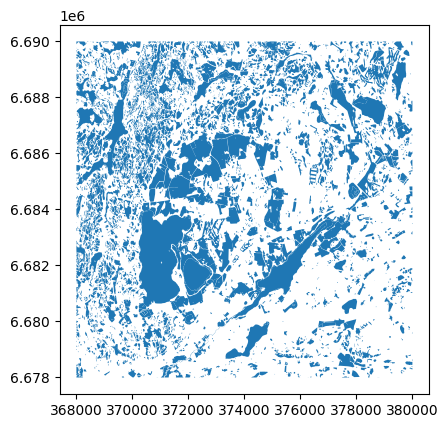

In [13]:
data.plot()

Voilá! It is indeed this easy to produce a map out of an geospatial data set.
Geopandas automatically positions your map in a way that it covers the whole
extent of your data.

:::{note}
If you live in the Helsinki region, you might recognise some of the shapes in
the map ;)
:::

### Geometries in geopandas

Geopandas takes advantage of shapely’s geometry objects. Geometries are stored
in a column called *geometry*.

Let’s print the first 5 rows of the column `geometry`:

In [14]:
data.geometry.head()

0    POLYGON ((379394.248 6689991.936, 379389.790 6...
1    POLYGON ((378980.811 6689359.377, 378983.401 6...
2    POLYGON ((378804.766 6689256.471, 378817.107 6...
3    POLYGON ((379229.695 6685025.111, 379233.366 6...
4    POLYGON ((379825.199 6685096.247, 379829.651 6...
Name: geometry, dtype: geometry

Lo and behold, the `geometry` column contains familiar-looking values:
*Well-Known Text* (WKT) strings. Don’t be fooled, they are, in fact,
`shapely.geometry` objects (you might remember from [last week’s
lesson](../lesson-1/geometry-objects)) that, when `print()`ed or type-cast into
a `str`, are represented as a WKT string).

Since the geometries in a `GeoDataFrame` are stored as shapely objects, we can
use **shapely methods** to handle geometries in geopandas.

Let’s take a closer look at (one of) the polygon geometries in the terrain data
set, and try to use some of the shapely functionality we are already familiar
with. For the sake of clarity, first, we’ll work with the geometry of the very
first record, only:

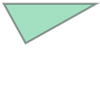

In [15]:
# The value of the column `geometry` in row 0:
data.at[0, "geometry"]

In [16]:
# Print information about the area 
print(f"Area: {round(data.at[0, 'geometry'].area)} m².")

Area: 76 m².


:::{admonition} Area measurement unit
:class: note

Here, we know the coordinate reference system (CRS) of the input data set. The
CRS also defines the unit of measurement (in our case, metres). That’s why we
can print the computed area including an area measurement unit (square metres).
:::


Let’s do the same for multiple rows, and explore different options of how to.
First, use the reliable and tried `iterrows()` pattern we learned in [lesson 6
of the Geo-Python course](https://geo-python.github.io/site/notebooks/L6/pandas/advanced-data-processing-with-pandas.html#Iterating-rows-and-using-self-made-functions-in-Pandas).

In [17]:
# Iterate over the first 5 rows of the data set
for index, row in data[:5].iterrows():
    polygon_area = row["geometry"].area
    print(f"The polygon in row {index} has a surface area of {polygon_area:0.1f} m².")

The polygon in row 0 has a surface area of 76.0 m².
The polygon in row 1 has a surface area of 2652.1 m².
The polygon in row 2 has a surface area of 3185.6 m².
The polygon in row 3 has a surface area of 13075.2 m².
The polygon in row 4 has a surface area of 3980.7 m².


As you see, all **pandas** functions, such as the `iterrows()` method, are
available in geopandas without the need to call pandas separately. Geopandas
builds on top of pandas, and it inherits most of its functionality.

Of course the `iterrows()` pattern is not the most convenient and efficient way
to calculate the area of many rows. Both `GeoSeries` (geometry columns) and
`GeoDataFrame`s have an `area` property:

In [18]:
# the `area` property of a `GeoDataFrame`
data.area

0          76.027392
1        2652.054186
2        3185.649995
3       13075.165279
4        3980.682621
            ...     
4299     2651.800270
4300      376.503380
4301      413.942555
4302     3487.927677
4303     1278.963199
Length: 4304, dtype: float64

In [19]:
# the `area property of a `GeoSeries`
data["geometry"].area

0          76.027392
1        2652.054186
2        3185.649995
3       13075.165279
4        3980.682621
            ...     
4299     2651.800270
4300      376.503380
4301      413.942555
4302     3487.927677
4303     1278.963199
Length: 4304, dtype: float64

It’s straight-forward to create a new column holding the area:

In [20]:
data["area"] = data.area
data

GROUP  CLASS                                           geometry  \
0        64  32421  POLYGON ((379394.248 6689991.936, 379389.790 6...   
1        64  32421  POLYGON ((378980.811 6689359.377, 378983.401 6...   
2        64  32421  POLYGON ((378804.766 6689256.471, 378817.107 6...   
3        64  32421  POLYGON ((379229.695 6685025.111, 379233.366 6...   
4        64  32421  POLYGON ((379825.199 6685096.247, 379829.651 6...   
...     ...    ...                                                ...   
4299     64  36313  POLYGON ((375668.607 6682942.062, 375671.489 6...   
4300     64  36313  POLYGON ((368411.063 6679328.990, 368411.424 6...   
4301     64  36313  POLYGON ((368054.608 6679164.737, 368059.602 6...   
4302     64  36313  POLYGON ((368096.331 6678000.000, 368090.276 6...   
4303     64  36313  POLYGON ((368000.666 6678460.142, 368000.000 6...   

              area  
0        76.027392  
1      2652.054186  
2      3185.649995  
3     13075.165279  
4      3980.682621  
...            ...  
4299   2651.800270  
4300    376.503380  
4301    413.942555  
4302   3487.927677  
4303   1278.963199  

[4304 rows x 4 columns]

:::{admonition} Descriptive statistics
:class: hint

Do you remember how to calculate the *minimum*, *maximum*, *sum*, *mean*, and
*standard deviation* of a pandas column? ([Lesson 5 of
Geo-Python](https://geo-python-site.readthedocs.io/en/latest/notebooks/L5/exploring-data-using-pandas.html#descriptive-statistics))
What are these values for the area column of the data set?
:::



## Write a subset of data to a file

[In the previous section](./vector-data-io.md#writing-geospatial-data-to-a-file), we
learnt how to write an entire `GeoDataFrame` to a file. We can also write a
filtered subset of a data set to a new file, e.g., to help with processing
complex data sets.

First, isolate the lakes in the input data set (class number `36200`, see table
above):

In [21]:
lakes = data[data.CLASS == 36200]

Then, plot the data subset to visually check whether it looks correct:

<AxesSubplot: >

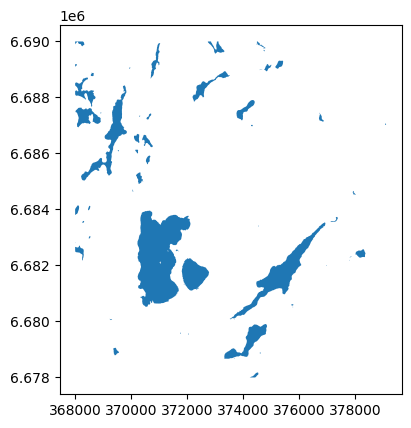

In [22]:
lakes.plot()

And finally, write the filtered data to a Shapefile:

In [23]:
lakes.to_file(DATA_DIRECTORY / "finland_topographic_database" / "lakes.shp")

Check the [Vector Data I/O](vector-data-io) section to see which data formats
geopandas can write to.



## Grouping data

A particularly useful method of (geo)pandas’ data frames is their grouping
function: [`groupby()`](https://pandas.pydata.org/docs/user_guide/groupby.html)
can **split data into groups** based on some criteria, **apply** a function
individually to each of the groups, and **combine** results of such an
operation into a common data structure.

We have used this function earlier: in [Geo-Python, 
lesson 6](https://geo-python-site.readthedocs.io/en/latest/notebooks/L6/advanced-data-processing-with-pandas.html#aggregating-data-in-pandas-by-grouping).

We can use *grouping* here to split our input data set into subsets that relate
to each of the `CLASS`es of terrain cover, then save a separate file for each
class.

Let’s start this by, again, taking a look at how the data set actually looks
like:

In [24]:
data.head()

GROUP  CLASS                                           geometry  \
0     64  32421  POLYGON ((379394.248 6689991.936, 379389.790 6...   
1     64  32421  POLYGON ((378980.811 6689359.377, 378983.401 6...   
2     64  32421  POLYGON ((378804.766 6689256.471, 378817.107 6...   
3     64  32421  POLYGON ((379229.695 6685025.111, 379233.366 6...   
4     64  32421  POLYGON ((379825.199 6685096.247, 379829.651 6...   

           area  
0     76.027392  
1   2652.054186  
2   3185.649995  
3  13075.165279  
4   3980.682621

Remember: the `CLASS` column contains information about a polygon’s land use
type. Use the
[`pandas.Series.unique()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html)
method to list all values that occur:

In [25]:
data["CLASS"].unique()

array([32421, 32200, 34300, 34100, 34700, 32417, 32500, 32112, 32111,
       32611, 32612, 32800, 32900, 35300, 35412, 35411, 35421, 33000,
       33100, 36200, 36313])

To group data, use the data frame’s `groupby()` method, supply a column name as
a parameter:

In [26]:
grouped_data = data.groupby("CLASS")
grouped_data

So, `grouped_data` is a `DataFrameGroupBy` object. Inside a `GroupBy` object,
its property `groups` is a dictionary that works as a lookup table: it records
which rows belong to which group. The keys of the dictionary are the unique
values of the grouping column:

In [27]:
grouped_data.groups

{32111: [3116], 32112: [3115], 32200: [103, 104], 32417: [3112], 32421: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], 32500: [3113, 3114], 32611: [3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201

However, one can also simply iterate over the entire `GroupBy` object. Let’s
count how many rows of data each group has:

In [28]:
for key, group in grouped_data:
    print(f"Terrain class {key} has {len(group)} rows.")

Terrain class 32111 has 1 rows.
Terrain class 32112 has 1 rows.
Terrain class 32200 has 2 rows.
Terrain class 32417 has 1 rows.
Terrain class 32421 has 103 rows.
Terrain class 32500 has 2 rows.
Terrain class 32611 has 261 rows.
Terrain class 32612 has 11 rows.
Terrain class 32800 has 81 rows.
Terrain class 32900 has 26 rows.
Terrain class 33000 has 5 rows.
Terrain class 33100 has 117 rows.
Terrain class 34100 has 3003 rows.
Terrain class 34300 has 1 rows.
Terrain class 34700 has 3 rows.
Terrain class 35300 has 134 rows.
Terrain class 35411 has 34 rows.
Terrain class 35412 has 449 rows.
Terrain class 35421 has 5 rows.
Terrain class 36200 has 56 rows.
Terrain class 36313 has 8 rows.


There are, for instance, 56 lake polygons (class `36200`) in the input data set.

To obtain all rows that belong to one particular group, use the `get_group()`
method, which returns a brand-new `GeoDataFrame`:

In [29]:
lakes = grouped_data.get_group(36200)
type(lakes)

geopandas.geodataframe.GeoDataFrame

:::{caution}
The index in the new data frame stays the same as in the ungrouped input data
set. This can be helpful, for instance, when you want to join the grouped data
back to the original input data.
:::


## Write grouped data to separate files

Now we have all the necessary tools in hand to split the input data into
separate data sets for each terrain class, and write the individual subsets to
new, separate, files. In fact, the code looks almost too simple, doesn’t it?

In [30]:
# Iterate over the input data, grouped by CLASS
for key, group in data.groupby("CLASS"):
    # save the group to a new shapefile
    group.to_file(TOPOGRAPHIC_DATABASE_DIRECTORY / f"terrain_{key}.shp")

:::{admonition} File name
:class: attention

We used a `pathlib.Path` combined with an f-string to generate the new output
file’s path and name. Check this week’s section [Managing file
paths](managing-file-paths), and [Geo-Python lesson
2](https://geo-python-site.readthedocs.io/en/latest/notebooks/L2/Python-basic-elements.html#f-string-formatting)
to revisit how they work.
:::


## Extra: save summary statistics to CSV spreadsheet

Whenever the results of an operation on a `GeoDataFrame` do not include a
geometry, the output data frame will automatically become a ‘plain’
`pandas.DataFrame`, and can be saved to the standard table formats.

One interesting application of this is to save basic descriptive statistics of
a geospatial data set into a CSV table. For instance, we might want to know the
area each terrain class covers. 

Again, we start by grouping the input data by terrain classes, and then compute
the sum of each classes’ area. This can be condensed into one line of code:

In [31]:
area_information = data.groupby("CLASS").area.sum()
area_information

CLASS
32111    1.833747e+03
32112    2.148168e+03
32200    1.057368e+05
32417    1.026678e+02
32421    6.792797e+05
32500    1.097467e+05
32611    1.314807e+07
32612    1.073431e+05
32800    1.407231e+06
32900    6.158391e+05
33000    6.594647e+05
33100    3.769076e+06
34100    1.236289e+07
34300    1.627079e+03
34700    2.785751e+03
35300    1.382940e+06
35411    3.928004e+05
35412    4.708321e+06
35421    6.786374e+04
36200    9.986966e+06
36313    4.346029e+04
Name: area, dtype: float64

We can then save the resulting table into a CSV file using the standard pandas
approach we learned about in [Geo-Python
lesson 5](https://geo-python-site.readthedocs.io/en/latest/notebooks/L5/processing-data-with-pandas.html#writing-data-to-a-file).

In [32]:
area_information.to_csv(TOPOGRAPHIC_DATABASE_DIRECTORY / "area_by_terrain_class.csv")